In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import progressbar as pb


Using TensorFlow backend.


In [2]:
sample_data_file = "driving_log.csv"
sample_data = pd.read_csv(sample_data_file, sep = ",", skipinitialspace=True)


In [3]:
sample_data.index

RangeIndex(start=0, stop=8036, step=1)

In [4]:
angle_adjust = 0.21

center = sample_data[["center","steering"]]
left = sample_data[["left","steering"]]
right = sample_data[["right","steering"]]

left['steering'] = left['steering'] + angle_adjust
right['steering'] = right['steering'] - angle_adjust

center.columns=["path","steering"]
left.columns=["path","steering"]
right.columns=["path","steering"]


data = left.append(center).append(right)




/Users/Gon/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Gon/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
##########
# pip install prograssbar2 for python 3.5
# http://stackoverflow.com/questions/13520622/script-to-show-progress
# http://pythonhosted.org/progressbar2/usage.html#bar-with-custom-widgets
#########

progress = pb.ProgressBar(maxval = len(data)).start()
progvar = 0



N/A% (0 of N/A) |                                                     | Elapsed Time: 0:00:00 ETA:  --:--:--

In [6]:

# path = data["path"].tolist()
# images = []
# images_flipped= []

# progress = pb.ProgressBar(maxval = len(data)).start()
# progvar = 0
# for img in path:
    
#     image =cv2.imread(img)
#     images.append(image)
#     image_flip = cv2.flip(image, 1)
#     images_flipped.append(image_flip)
    
#     progress.update(progvar)
#     progvar += 1
# print("finish loading images to array")
# #     print('path: ',img)
# #     plt.imshow(image)
# #     plt.imshow(image_flip)
# #     print('image', image)
# #     print('image flip: ', image_flip)
# #     print('images list: ', images)
# #     print('flip list: ', images_flipped)
    
    
# steering = data["steering"].tolist()

# print("done")


In [7]:
# #flip 
# data["steering_flip"] = -data['steering']
# steering_flipped = data['steering_flip'].tolist()
# #put together
# images_ready = images+images_flipped
# steering_ready = steering+steering_flipped

# print("all set")
# # X_train = np.array(images_ready)
# # Y_train = np.array(steering_ready)

# print('done')

In [8]:
def steering_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,20), (0,0))))
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation = "relu"))
#     model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(32,5,5,subsample=(2,2),activation = "relu"))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation = "relu"))
    model.add(Convolution2D(64,3,3,activation = "relu"))
    model.add(Convolution2D(64,3,3,activation = "relu"))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation = "relu"))
    model.add(Dense(1))
#     model.summary()
    return model






In [39]:
def image_process(db):
    path = db["path"].tolist()
    images = []
    images_flipped= []

#     progress = pb.ProgressBar(maxval = len(db)).start()
#     progvar = 0
    
    for img in path:
        image =cv2.imread(img)
        images.append(image)
        image_flip = cv2.flip(image, 1)
        images_flipped.append(image_flip)

#         progress.update(progvar)
#         progvar += 1
#     print("finish loading images to array")
    
    steering = db["steering"].tolist()
    db["steering_flip"] = -db['steering']
    steering_flipped = db['steering_flip'].tolist()
    #put together
    images_ready = images+images_flipped
    steering_ready = steering+steering_flipped
    
    images_set, steering_set = shuffle(images_ready, steering_ready)
    return images_set, steering_set

In [11]:
def generator(x , y , batch_size):
    num_samples = len(x)
    while 1: # Loop forever so the generator never terminates
        shuffle(x, y)
        for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

            images = x[offset:offset+batch_size]
            angles = y[offset:offset+batch_size]
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)


In [40]:
def generator2(db, batch_size):
    
    num_samples = len(db)
    while 1: # Loop forever so the generator never terminates
#         shuffle(x, y)
        for offset in range(0, num_samples, batch_size):

            batch_db = db[offset:offset+batch_size]
            images, angles = image_process(batch_db)
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)
    


In [97]:
epoch = 10
batch = 64

# x_train, y_train = image_process(data)
# x_test, y_test = image_process(center)
# train_generator = generator(x_train, y_train, batch)
# test_generator = generator(x_test, y_test, batch)

train_generator = generator2(data, batch)
test_generator = generator2(center, batch)

model = steering_model()
model.compile(optimizer="adam", loss = "mse")
history = model.fit_generator(train_generator, samples_per_epoch= len(data)*2, validation_data=test_generator, 
                    nb_val_samples=len(center), nb_epoch=epoch)
# model.fit(X_train,Y_train, validation_split = 0.2, shuffle = True, nb_epoch=epoch)
model.save('model2.h5')

print("model trained")


json_str = model.to_json()
with open('model.json','w') as f:
    f.write(json_str)
print('json file saved')

Epoch 1/10


/Users/Gon/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 6400/48216 [==>...........................] - ETA: 900s - loss: 0.0628 

KeyboardInterrupt: 

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 70, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 33, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 15, 77, 32)    19232       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [45]:
steering = data["steering"].tolist()
data["steering_flip"] = -data['steering']
steering_flipped = data['steering_flip'].tolist()
#put together
steering_ready_to_draw = steering+steering_flipped


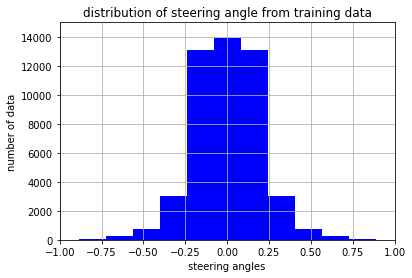

In [75]:
plt.hist(steering_ready_to_draw, 15, facecolor='blue')
plt.xlabel('steering angles')
plt.ylabel('number of data')
plt.title('distribution of steering angle from training data')
plt.axis([-1, 1, 0, 15000 ])
plt.grid(True)
plt.show()

In [99]:
hist= history.history

In [100]:
training_set, validation_set = hist["loss"], hist["val_loss"]

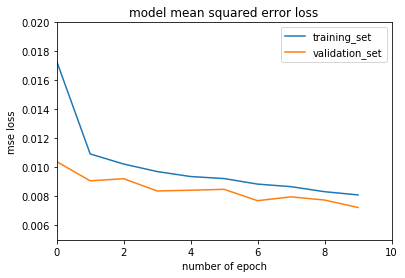

In [118]:
plt.plot(training_set, label= "training_set")
plt.plot(validation_set, label = "validation_set")
plt.axis([0,10,0.005,0.020])
plt.legend()
plt.xlabel('number of epoch')
plt.ylabel('mse loss')
plt.title('model mean squared error loss')
plt.show()